In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
%matplotlib inline

In [2]:
words = open('/content/drive/MyDrive/names.txt','r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
s2i = {s:i+1 for i, s in enumerate(chars)}
s2i['.'] = 0
i2s = {i:s for s,i in s2i.items()}
vocab_size = len(i2s)

In [4]:
VOCAB_SIZE = len(i2s)
EMBEDDING_SIZE = 10
NUM_NEURONS = 64
BLOCK_SIZE = 3

In [22]:
block_size = 3
def generate_dataset(words):

  x, y = [], []
  for word in words:
    context = [0] * block_size
    for ch in word:
      ix = s2i[ch]
      x.append(context)
      y.append(ix)

      context = context[1:] + [ix]

  x = torch.tensor(x)
  y = torch.tensor(y)
  return x,y

X,Y = generate_dataset(words[:6])
#print(X,Y)

In [21]:
def split_dataset(words):
  random.seed(42)
  random.shuffle(words)
  n1 = int(0.8*len(words))
  n2 = int(0.9*len(words))

  x_train, y_train = generate_dataset(words[:n1])
  x_val, y_val = generate_dataset(words[n1:n2])
  x_test, y_test = generate_dataset(words[n2:])

  return x_train, y_train, x_val, y_val, x_test, y_test

In [23]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_dataset(words)

In [24]:
X_train, Y_train

(tensor([[ 0,  0,  0],
         [ 0,  0, 25],
         [ 0, 25, 21],
         ...,
         [ 8, 15, 12],
         [15, 12,  4],
         [12,  4,  1]]),
 tensor([25, 21,  8,  ...,  4,  1, 14]))

In [8]:
# @title Initialize
n_embd = EMBEDDING_SIZE
n_hidden = NUM_NEURONS

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((VOCAB_SIZE, n_embd),                   generator=g)
W1 = torch.randn((n_embd*BLOCK_SIZE, n_hidden),          generator=g) * ((5/3)/(n_embd*BLOCK_SIZE)**0.5)
b1 = torch.randn(n_hidden,                               generator=g) * 0.1
W2 = torch.randn((n_hidden, VOCAB_SIZE),                 generator=g) * 0.1
b2 = torch.randn(VOCAB_SIZE,                             generator=g) * 0.1

bngain = torch.randn((1,n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1,n_hidden)) * 0.1

bnmean_running = torch.zeros((1, n_hidden)) # initialize 0 mean
bnstd_running = torch.ones((1, n_hidden)) # initialize 1 std

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True
  print(p.shape)

4137
torch.Size([27, 10])
torch.Size([30, 64])
torch.Size([64])
torch.Size([64, 27])
torch.Size([27])
torch.Size([1, 64])
torch.Size([1, 64])


In [9]:
# utility function we wil use later when comparing manual gradients to Pytorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [ ]:
# @title previous_training
'''
max_epoch = 200000
batch_size = 32

for i in range(max_epoch):

  idx = random.randint(0,X_train.shape[0], (batch_size,), generator=g)
  Xb = X_train[idx]
  Yb = Y_train[idx]

  emb = C[Xb]
  emb_cat = emb.view((emb.shape[0], -1))
  hpreact = emb_cat @ W1 + b1

  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)

  hpreact = bngain * (hpreact-bnmeani)/bnstdi  + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running  = 0.999 * bnstd_running  + 0.001 * bnstdi

  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.0001 if i<100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
'''

In [10]:
# @title training/forward pass
#initialization
batch_size = 32
n = batch_size
ix = torch.randint(0, X_train.shape[0], (n,), generator=g)
Xb, Yb = X_train[ix], Y_train[ix]

In [33]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
# Linear layer 1
hprebn = embcat @ W1 + b1
# Batch-norm layer
bnmeani = 1/n * hprebn.sum(0, keepdim=True)
bndiff  = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar   = 1/(n-1) * (bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw   = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact)
# Linear layer 2
logits = h @ W2 + b2
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # substract max for numerical stability
counts  = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum **-1 # if i use (1.0 / counts_sum) instead then I can't get backprop to be bit exact..
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()


# Pytorch Backward pass:
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits,
          logit_maxes, logits, h, hpreact, bnraw, bnvar_inv, bnvar, bndiff2,
          bndiff, hprebn, bnmeani, embcat, emb]:
  t.retain_grad()

loss.backward()
loss

tensor(3.3739, grad_fn=<NegBackward0>)

In [ ]:
'''
broadcasting/replication in the forward pass results in a summation in the backward pass, over the same dimension

summation in the forward pass results in a broadcasting/replication in the backward pass, over the same dimension
'''

'\nbroadcasting/replication in the forward pass results in a summation in the backward pass, over the same dimension\n\nsummation in the forward pass results in a broadcasting/replication in the backward pass, over the same dimension\n'

In [34]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

# -----------------
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (probs**-1) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs

dcounts_sum = -1.0 * (counts_sum**-2) * dcounts_sum_inv
dcounts = dcounts + (torch.ones_like(counts) * dcounts_sum)

dnorm_logits = norm_logits.exp() * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = -1.0 * dnorm_logits.sum(1, keepdim=True)

# idx = logits.max(1).indices
# temp = torch.zeros_like(logits)
# temp[range(n), idx] = dlogit_maxes.view(-1)
# dlogits = dlogits + temp
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = (1.0 * dlogits).sum(0)
dhpreact = (1.0 - h**2) * dh

dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnbias = (1.0 * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0,keepdim=True)
dbnvar = (-0.5 * (bnvar+1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar
dbndiff += 2.0 * bndiff * dbndiff2
dbnmeani = -1.0 * dbndiff.sum(0, keepdim=True) # !!!!!!!!!!!!!!!!!!!!!!!!!
#dbnmeani = (-torch.ones_like(bndiff) * dbndiff).sum(0,keepdim=True)  # another way to implement the above line of code
dhprebn = 1.0 * dbndiff.clone()
dhprebn += (1.0/n) * torch.ones_like(hprebn) * dbnmeani

dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = 1.0 * dhprebn.sum(0)

demb = dembcat.view(dembcat.shape[0],BLOCK_SIZE,n_embd)
# demb = dembcat.view(emb.shape)

dC = torch.zeros_like(C)
for i in range(demb.shape[0]): # range(Xb.shape[0])
  for j in range(demb.shape[1]): # range(Xb.shape[1])
    ix = Xb[i,j] # getting the character(stored as an int) stored at example i, context j
    dC[ix] += demb[i,j] # indexing into dC with the correct index of the character, and storing the i example, j embedding value
                       # remember if one character appears multiple times(which will definately happen), we have to add the gradients for all their appearances

# -----------------

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bngain          | exact: False | approximate: True  | maxdiff: 3.259629011154175e-09
bnbias          | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09
bnraw   

In [ ]:
q = (1.0/n-1) * torch.ones_like(bndiff2) * dbnvar


In [ ]:
dC = torch.zeros_like(C)
for i in range(demb.shape[0]): # range(Xb.shape[0])
  for j in range(demb.shape[1]): # range(Xb.shape[1])
    ix = Xb[i,j]
    dC[ix] = demb[i,j]

In [ ]:
logits = h @ W2 + b2
dh = dlogits @ W2.T
dW2 = h.T @ dlogits

In [ ]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.366321325302124 diff: 0.0


In [ ]:
# backward pass

# -----------------
# YOUR CODE HERE :)
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -=1
dlogits /= n
#dlogits = None # TODO. my solution is 3 lines
# -----------------

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09


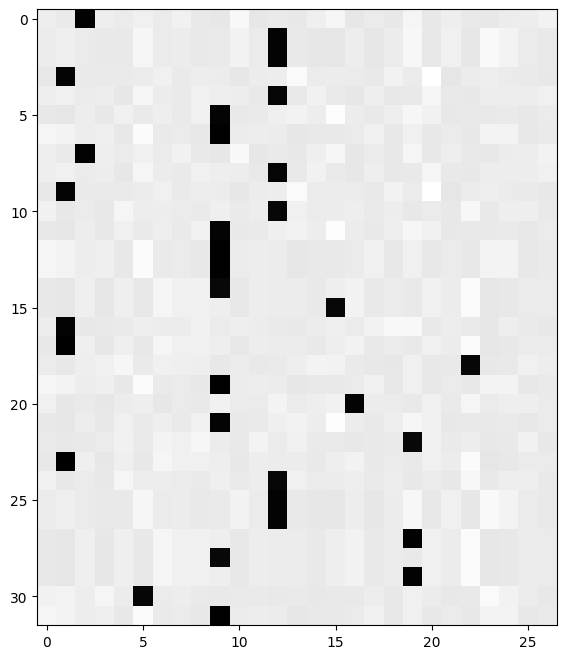

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [ ]:
F.softmax(logits, 1)[0]

tensor([0.0423, 0.0285, 0.0216, 0.0438, 0.0305, 0.0538, 0.0292, 0.0550, 0.0237,
        0.0158, 0.0895, 0.0140, 0.0269, 0.0188, 0.0478, 0.0784, 0.0144, 0.0331,
        0.0173, 0.0722, 0.0183, 0.0458, 0.0219, 0.0201, 0.0349, 0.0405, 0.0620],
       grad_fn=<SelectBackward0>)

In [ ]:
dlogits[0] * n

tensor([ 0.0423,  0.0285, -0.9784,  0.0438,  0.0305,  0.0538,  0.0292,  0.0550,
         0.0237,  0.0158,  0.0895,  0.0140,  0.0269,  0.0188,  0.0478,  0.0784,
         0.0144,  0.0331,  0.0173,  0.0722,  0.0183,  0.0458,  0.0219,  0.0201,
         0.0349,  0.0405,  0.0620], grad_fn=<MulBackward0>)

In [ ]:
probs.shape, counts.shape, counts_sum_inv.shape, counts_sum.shape

(torch.Size([32, 27]),
 torch.Size([32, 27]),
 torch.Size([32, 1]),
 torch.Size([32, 1]))

In [ ]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [ ]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)

# dhprebn = bngain * (hprebn.var(0,keepdim=True,unbiased=True)+1e-5)**-0.5 * \
#           (dhpreact - (dhpreact * (hprebn - hprebn.mean(0,keepdim=True))/torch.sqrt(hprebn.var(0,keepdim=True,unbiased=True)+1e-5)).sum(0,keepdim=True) * \
#            (1.0/(n-1.0))* (hprebn - hprebn.mean(0,keepdim=True))/torch.sqrt(hprebn.var(0,keepdim=True,unbiased=True)+1e-5) - \
#             (1.0/n)* dhpreact.sum(0,keepdim=True))
dhprebn = bngain*bnvar_inv * (dhpreact - (1.0/n)*dhpreact.sum(0) - 1.0/(n-1.0) * bnraw * (dhpreact*bnraw).sum(0) ) # TODO. my solution is 1 (long) line
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 1.3969838619232178e-09


In [ ]:
hprebn.shape, bnraw.shape, hpreact.shape, bngain.shape, dhpreact.shape, dhprebn.shape

(torch.Size([32, 64]),
 torch.Size([32, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([32, 64]))

In [ ]:
hprebn.var(0,keepdim=True).shape

torch.Size([1, 64])

In [11]:
vocab_size = len(i2s)
block_size = 3

In [33]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    # YOUR CODE HERE :)
    dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None

    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n

    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)

    dhpreact = (1.0 - h**2) * dh

    dbngain = (bnraw * dhpreact).sum(0,keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    #dhprebn = bngain*bnvar_inv* (dhpreact - (1.0/n)*dhpreact.sum(0) - 1.0/(n-1.0)*bnraw*(dhpreact*bnraw).sum(0))
    dhprebn = bngain*bnvar_inv * (dhpreact - (1.0/n)*dhpreact.sum(0) - 1.0/(n-1.0) * bnraw * (dhpreact*bnraw).sum(0) )

    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)

    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]


    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    #    break

12297
      0/ 200000: 3.6692
  10000/ 200000: 2.6081
  20000/ 200000: 2.0738
  30000/ 200000: 2.0348
  40000/ 200000: 2.7462
  50000/ 200000: 1.8951
  60000/ 200000: 1.7128
  70000/ 200000: 2.2002
  80000/ 200000: 2.2332
  90000/ 200000: 2.2126
 100000/ 200000: 2.1690
 110000/ 200000: 1.9334
 120000/ 200000: 2.3019
 130000/ 200000: 2.3595
 140000/ 200000: 2.0498
 150000/ 200000: 2.3067
 160000/ 200000: 2.3264
 170000/ 200000: 2.1122
 180000/ 200000: 2.6271
 190000/ 200000: 2.4931


In [ ]:
# 12297
#       0/ 200000: 3.7574

In [53]:
dhprebn.shape, hprebn.shape,embcat.shape, W1.shape,  b1.shape, emb.shape
#hprebn = embcat @ W1 + b1

(torch.Size([32, 64]),
 torch.Size([32, 64]),
 torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]),
 torch.Size([32, 3, 10]))

In [48]:
dlogits.shape,logits.shape, W2.shape, h.shape, dh.shape

(torch.Size([32, 27]),
 torch.Size([32, 27]),
 torch.Size([64, 27]),
 torch.Size([32, 64]),
 torch.Size([32, 64]))

In [14]:
#useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 3.3527612686157227e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(200,)          | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09
(27,)           | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09


In [34]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[X_train]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [35]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train, Y_train),
    'val': (X_val, Y_val),
    'test': (X_test, Y_test),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.114468574523926
val 2.1619627475738525


In [19]:
X_train.shape

torch.Size([23, 3])

In [36]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(i2s[i] for i in out))

novannalayahnzayvontrolaiancesonahengsttiakesmonyleaamnighsarayarelleylandraylanielsiellataleightonnavharlosteriellamillandricyonnegianasyufildonavioustenodylingstonjajvishristalansyndelinaalinglovelieanovinamareenateannaineynavarishellieshayleyaniyanahettenhagdoressoncelynnleightynnckareavrueksisvohamaryedencesiyahriofaylenyxkarickiamorionarionnibasourtynoryelleyiahondolynnanilanaygenvannonaediennerinniellouchelingorgelizyannattainavaubrylynnysenuettierafarettienairandilenelanielahilavyaneamajvinateemarlynniavanellisternettellisshiyanniqabaalinashunicharmyahiloryaiqonnykaedionnakarrycaspylieubadyneeganyxxissahaanaiahlanelleyanyannoniquelioksteosiahhinleenabyanahleyzeersinaisondalincierleyaanahadzielynnariusheishrilennyariahnielariusenavalisonmalizaarelinancarluyastinityennaharlezarpearabellouruphyleenatalyiahnendylenetraynabaleeleyarrynnerikolariyaharioruwatmaanahwlesseonorionatrevianahavkenslermonestolnparpennandelidvictonandynestephanyavarissilenessandrestonivianarahynettelisteannad

KeyboardInterrupt: ignored